[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/me-manu/gammaALPs/blob/master/docs/tutorials/mixing_ICM_structured_field.ipynb)

# Example to calculate photon-ALP oscillations from NGC 1275 in a cavity field

This notebook demonstrates how to calculate the photon-ALP transition probability for NGC 1275, the central AGN of the Perseus cluster. The assumed B-field environments are the same as in https://arxiv.org/abs/1908.03084, and include the cluster field and the magnetic field of the Milky Way. Electron density model parameters taken from https://iopscience.iop.org/article/10.1086/374923/fulltext/57155.text.html.

Note that in order to obtain the field used in 1908.03084, you have to set $\theta$ to 225° instead of 45° (adding 180°). This effectively inverts the sign of all field components. While this change of $\theta$ and the sign is irrelevant for the conversion probability, it changes the field along the line of sight and inverts the sign of the RM, as well.

If you haven't installed `gammaALPs` already, you can do so using `pip`. Just uncomment the line below:

In [1]:
#!pip install gammaALPs

In [2]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ebltable.tau_from_model import OptDepth

In [3]:
%matplotlib inline

### Set the ALP

Initialize an ALP object, that stores the ALP mass $m$ (in neV) and the coupling $g$ (in $10^{-11}\mathrm{GeV}^{-1}$).

In [4]:
m, g = 2, 100
alp = ALP(m,g)

## Set the source

Set the source properties (redshift and sky coordinates) in the ```Source``` containier

In [5]:
ngc1275 = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s')

### Init the module list

Initialize the list of transfer modules that will store the different magnetic field environments.

Energies are supplied in GeV as ```numpy.ndarray```

In [6]:
logEMeV = np.linspace(0.46709351, 6.53207135, num=183, endpoint=True)
EGeV = np.power(10, logEMeV - 3.)

Now initialize the initial photon polarization. Since we are dealing with a gamma-ray source, no ALPs are initially present in the beam (third diagonal element is zero). The polarization density matrix is normalized such that its trace is equal to one, $\mathrm{Tr}(\rho_\mathrm{in}) = 1$.

In [7]:
pin = np.diag((1.,1.,0.)) * 0.5

### Add modules:

Now we add propagation modules for the cluster, the EBL, and the Galactic magnetic field; run the module. Repeat for only the ICM field.

In [8]:
alp = ALP(m, g)
ml = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)
ml.add_propagation("ICMStructured",
                   0, # position of module counted from the source.
                   B0 = 8.3,  # rms of B field
                   R = 93,
                   theta = 225,
                   theta_rad=False,
                   pa=147,
                   pa_rad=False,
                   n0 = 3.9e-2,  # normalization of electron density
                   n2 = 4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                   r_abell = 500., # extension of the cluster
                   r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                   r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                   beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                   beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                   eta = 0 # scaling of B-field with electron denstiy
                   )
ml.add_propagation("EBL",1, eblmodel = 'dominguez') # EBL attenuation comes second, after beam has left cluster
ml.add_propagation("GMF",2, model = 'pshirkov', model_sym = 'BSS') # finally, the beam enters the Milky Way Field
px, py, pa = ml.run()



# again with only structured field

ml2 = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)
ml2.add_propagation("ICMStructured",
                   0, # position of module counted from the source.
                   B0 = 8.3,  # rms of B field
                   R = 93,
                   theta = 225,
                   theta_rad=False,
                   pa=147,
                   pa_rad=False,
                   n0 = 3.9e-2,  # normalization of electron density
                   n2 = 4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                   r_abell = 500., # extension of the cluster
                   r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                   r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                   beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                   beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                   eta = 0 # scaling of B-field with electron denstiy
                   )
px2, py2, pa2 = ml2.run()



environs.py: 578 --- INFO: Using inputted chi
environs.py:1196 --- INFO: Using inputted chi
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMStructured'>
   core.py: 658 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
environs.py: 578 --- INFO: Using inputted chi
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMStructured'>


## Plot the output

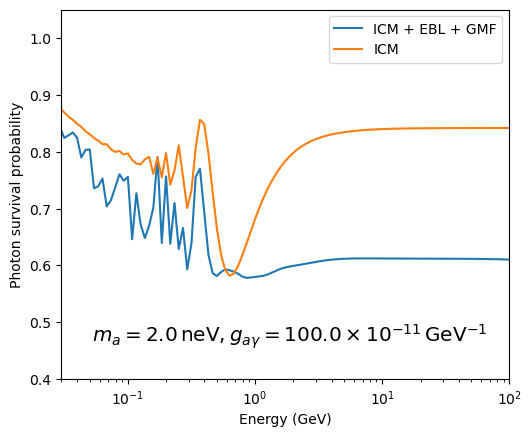

In [9]:
plt.plot(EGeV, px[0] + py[0], label='ICM + EBL + GMF')
plt.plot(EGeV, px2[0] + py2[0], label='ICM')
plt.xscale('log')
plt.yscale('linear')
plt.ylim(0.4, 1.05)
plt.xlim(3e-2, 1e2)
plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survival probability')
plt.legend(loc = 0, fontsize = 'medium')

plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}} = {1:.1f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(ml.alp.m,ml.alp.g),
             xy = (0.95,0.1), size = 'x-large', xycoords = 'axes fraction', ha = 'right')

plt.subplots_adjust(left = 0.2)

# Plot the B fields

Plot r vs B field components of structured field.

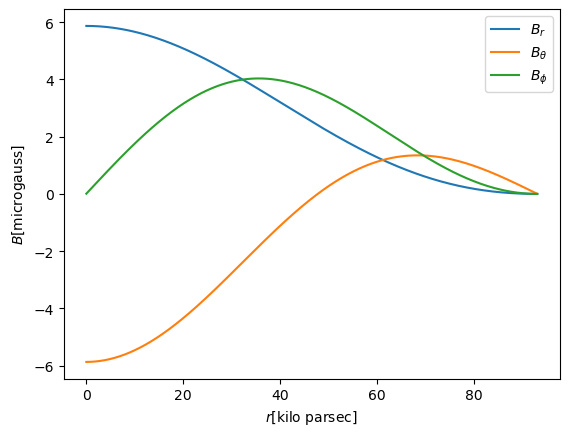

In [10]:
r = ml.modules[0].r
b_r = ml.modules[0]._Bfield_model.b_r
b_theta = ml.modules[0]._Bfield_model.b_theta
b_phi = ml.modules[0]._Bfield_model.b_phi
plt.plot(r, b_r, label='$B_r$')
plt.plot(r, b_theta, label=r'$B_\theta$')
plt.plot(r, b_phi, label=r'$B_\phi$')

plt.xlabel(r'$r [\mathrm{kilo\ parsec}]$')
plt.ylabel(r'$B [\mathrm{microgauss}]$')
#plt.xlabel(r'$r [\SI{}{\kilo\parsec}]$')  no funcionaban estas lineas
#plt.ylabel(r'$B [\SI{}{\micro\gauss}]$')
plt.legend()

## Plot electron density

We plot the electron density. Further, nel is used for calculating the RM at a later point.

Text(0.5, 0, '$r$ (kpc)')

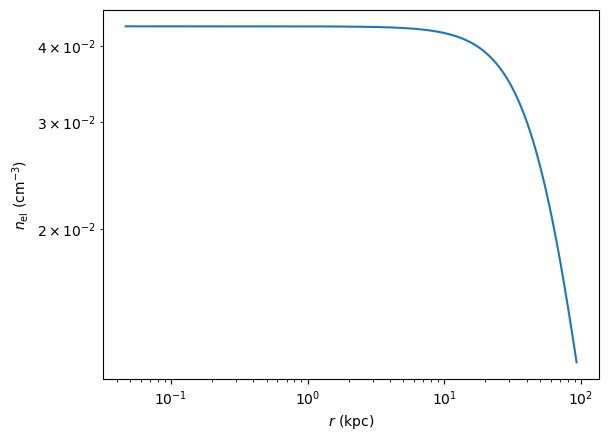

In [11]:
nel = ml.modules[0]._nelicm(r)   # in cm^-3
plt.plot(r, nel)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$n_\mathrm{el}$ (cm$^{-3}$)')
plt.xlabel('$r$ (kpc)')

## $B_{field}$ vs $n_e$

Text(0.5, 1.0, '$B_{field}$ vs $n_e$')

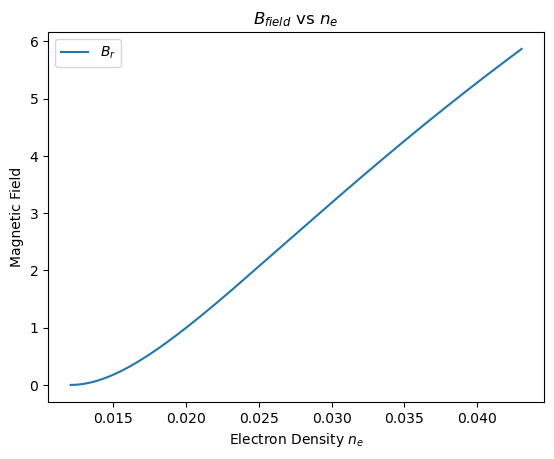

In [12]:
plt.plot(nel, b_r, label='$B_r$')


plt.legend()
plt.xlabel("Electron Density $n_e$")
plt.ylabel("Magnetic Field")
plt.title("$B_{field}$ vs $n_e$")

In [13]:
nel

array([0.04304998, 0.04304979, 0.0430494 , 0.04304883, 0.04304807,
       0.04304712, 0.04304598, 0.04304464, 0.04304312, 0.0430414 ,
       0.0430395 , 0.04303741, 0.04303512, 0.04303265, 0.04302998,
       0.04302712, 0.04302408, 0.04302084, 0.04301742, 0.0430138 ,
       0.04301   , 0.04300601, 0.04300182, 0.04299745, 0.04299289,
       0.04298813, 0.04298319, 0.04297806, 0.04297275, 0.04296724,
       0.04296154, 0.04295566, 0.04294958, 0.04294332, 0.04293687,
       0.04293024, 0.04292341, 0.0429164 , 0.0429092 , 0.04290181,
       0.04289424, 0.04288647, 0.04287853, 0.04287039, 0.04286207,
       0.04285356, 0.04284487, 0.04283599, 0.04282692, 0.04281767,
       0.04280823, 0.04279861, 0.0427888 , 0.04277881, 0.04276864,
       0.04275828, 0.04274773, 0.04273701, 0.0427261 , 0.042715  ,
       0.04270372, 0.04269226, 0.04268062, 0.0426688 , 0.04265679,
       0.0426446 , 0.04263223, 0.04261968, 0.04260695, 0.04259404,
       0.04258094, 0.04256767, 0.04255422, 0.04254059, 0.04252

In [14]:
b_r

array([5.86898180e+00, 5.86894590e+00, 5.86887411e+00, 5.86876642e+00,
       5.86862283e+00, 5.86844336e+00, 5.86822799e+00, 5.86797674e+00,
       5.86768961e+00, 5.86736659e+00, 5.86700771e+00, 5.86661295e+00,
       5.86618233e+00, 5.86571585e+00, 5.86521352e+00, 5.86467535e+00,
       5.86410135e+00, 5.86349151e+00, 5.86284586e+00, 5.86216439e+00,
       5.86144713e+00, 5.86069408e+00, 5.85990524e+00, 5.85908064e+00,
       5.85822029e+00, 5.85732418e+00, 5.85639235e+00, 5.85542480e+00,
       5.85442155e+00, 5.85338260e+00, 5.85230798e+00, 5.85119770e+00,
       5.85005178e+00, 5.84887023e+00, 5.84765307e+00, 5.84640031e+00,
       5.84511198e+00, 5.84378809e+00, 5.84242866e+00, 5.84103371e+00,
       5.83960327e+00, 5.83813734e+00, 5.83663596e+00, 5.83509914e+00,
       5.83352690e+00, 5.83191927e+00, 5.83027627e+00, 5.82859793e+00,
       5.82688426e+00, 5.82513529e+00, 5.82335105e+00, 5.82153156e+00,
       5.81967685e+00, 5.81778695e+00, 5.81586187e+00, 5.81390165e+00,
      

## Visualisation of the magnetic field

We can further plot a field line to illustrate that the field really is structured, opposed to a gaussian turbulence field.

For this, we use the equation determining a single field line
$\newcommand{\vert}{|}\newcommand{\vect}{\mathbf}\vect{x}_{i+1} =  \vect{x}_{i} + \frac{\vect{B}(\vect{x}_i)}{\left \vert \vect{B}(\vect{x}_i) \right \vert} \Delta s$
for a small $\Delta s$.


In [15]:
import numpy as np
import matplotlib as mpl
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

### Functions and constants

In the following block, we define the neccessary functions (field components etc.), some constants and transformations of coordinates and vector fields to be used.

In [16]:
def field_line(x_0, steps, ds):
    x = np.zeros((steps, 3))
    x[0] = x_0
    for i in range(steps-1):
        x[i+1] = integrate(x[i], ds)
    return x

def integrate(x_prev, ds):
    '''Returns next point along field line, given some starting point x_prev and a small increment ds'''
    r, theta, phi = cart_to_sphere(x_prev[0], x_prev[1], x_prev[2])
    B_sph = B_sphere(r, theta, phi)
    B_cart = np.matmul(trafo(r, theta, phi), B_sph.transpose()).transpose()
    norm = np.linalg.norm(B_cart)
    x_new = x_prev + B_cart / norm * ds
    return x_new


def cart_to_sphere(x, y, z):
    '''Coordinate transformation from cartesian to spherical.'''
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return r, theta, phi

def sphere_to_cart(r, theta, phi):
    '''Coordinate transformation from spherical to cartesian'''
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z


def trafo(r, theta, phi):
    '''Returns trafo used for vector fields, i.e. Field A cartesian = S * Field A spherical. S is returned'''
    mat = np.array([[np.sin(theta) * np.cos(phi), np.cos(theta) * np.cos(phi), -np.sin(phi)],
                    [np.sin(theta) * np.sin(phi), np.cos(theta) * np.sin(phi), np.cos(phi)],
                    [np.cos(theta), -np.sin(theta), 0]])
    return mat


'''Constants used for field definitions'''
alpha = 5.7634591968
c = 1
F_0 = c * (alpha * np.cos(alpha) - np.sin(alpha)) * alpha**2


def b_r(r, theta):
    val = 2 * np.cos(theta) * f(r) / r**2
    return val


def b_theta(r, theta):
    val = - np.sin(theta) * f_prime(r) / r
    return val


def b_phi(r, theta):
    val = alpha * np.sin(theta) * f(r) / r
    return val


def f(r):
    return c * (alpha * np.cos(alpha * r) - np.sin(alpha * r) / r) \
           - F_0 * r**2 / alpha**2


def f_prime(r):
    return c * ( - alpha**2 * np.sin(alpha * r) \
                - alpha * np.cos(alpha * r) / r \
                + np.sin(alpha * r) / r**2) \
               - 2 * F_0 * r / alpha**2

def B_sphere(r, theta, phi):
    return np.array([[b_r(r, theta), b_theta(r, theta), b_phi(r, theta)]])


def norm(r):
    return np.sqrt(r[:, :, :, 0]**2)

### Plotting the field line
We plot an "interactive" field line, in the sense that you can rotate it around in space!

Because pyplot lacks a proper function for coloured 3D plots, we use instead a scatter with some colormap.

<IPython.core.display.Javascript object>


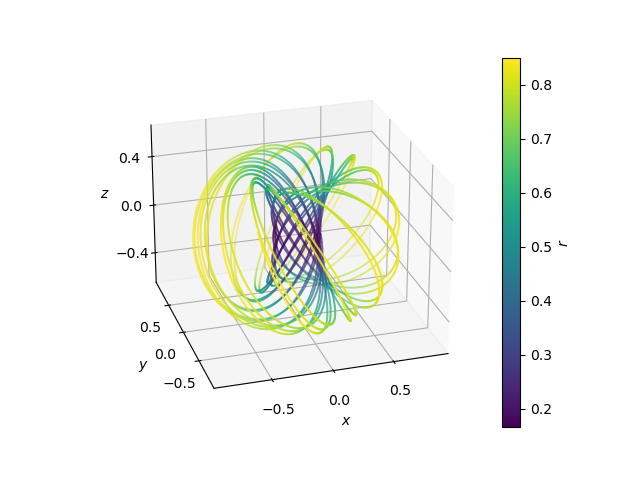

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15444\1881364441.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [17]:
%matplotlib notebook
# so that we can have an interactive plot!

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')


# start a field line at r=0.2, theta=pi / 2 (on the equator), phi=0
# choose some stepsize ds=0.001 and integrate 100000 steps

ds = 0.001
steps = 100000

#if you want to plot multiple field lines, change this for loop
for phi in np.linspace(0, 2 * np.pi, num=1):
    x_0 = sphere_to_cart(0.2, np.pi / 2, phi)
    x = field_line(x_0, steps, ds)
    #print(x)
    #plot only every 10th point to save memory and time
    line = ax.scatter(x[::10, 0], x[::10, 1], x[::10, 2],
                      c=np.linalg.norm(x[::10], axis=-1),
                      cmap=plt.get_cmap('viridis'),
                      s=1, marker='.')
cbar = fig.colorbar(line, ax=ax, label='$r$')
ax.set_xticks((-0.5, 0, 0.5))
ax.set_yticks((-0.5, 0, 0.5))
ax.set_zticks((-0.4, 0, 0.4))
ax.view_init(elev=25, azim=-107)

# Calculate rotation measure

Faraday RM can be calculated via a method of the structured field model, arguments areelectron density evaluated at r = structured_field.r in cm^-3

In [18]:
ml.modules[0].Bfield_model.rotation_measure(nel)   # in rad * m^-2

7309.771388898837

Taylor et al. (2006) found RM values between 6500 and 7500 rad m^-2